In [0]:
!git clone https://github.com/DeepWok/mase.git
%cd mase
!python3 -m pip install -e . -vvv

from google.colab import drive
drive.mount('/content/drive')

Removed build tracker: '/tmp/pip-build-tracker-if6a50zx'
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tutorial 3: Running Quantization-Aware Training (QAT) on Bert

In this tutorial, we'll build on top of Tutorial 2 by taking the Bert model fine tuned for sequence classification and running Mase's quantization pass. First, we'll run simple Post-Training Quantization (PTQ) and see how much accuracy drops. Then, we'll run some further training iterations of the quantized model (i.e. QAT) and see whether the accuracy of the trained quantized model approaches the accuracy of the original (full-precision) model.

In [32]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can create a MaseGraph for Bert by running the following cell.

In [ ]:
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

If you have previously ran the tutorial on LoRA Finetuning, run the following cell to import the fine tuned checkpoint.

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
from pathlib import Path
from chop import MaseGraph


mg = MaseGraph.from_checkpoint(f"/content/tutorial_2_lora")

/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loaded metadat

## Post-Training Quantization (PTQ)

Here, we simply quantize the model and evaluate the effect in its accuracy. First, let's evaluate the model accuracy before quantization (if you're coming from Tutorial 2, this should be the same as the post-LoRA evaluation accuracy). As seen in Tutorial 2, we can use the `get_tokenized_dataset` and `get_trainer` utilities to generate a HuggingFace `Trainer` instance for training and evaluation.

In [27]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.83816


To run the quantization pass, we pass a quantization configuration dictionary as argument. This defines the quantization mode, numerical format and precision for each operator in the graph. We'll run the quantization in "by type" mode, meaning nodes are quantized according to their `mase_op`. Other modes include by name and by regex name. We'll quantize all activations, weights and biases in the model to fixed-point with the same precision. This may be sub-optimal, but works as an example. In future tutorials, we'll see how to run the `search` flow in `Mase` to find optimal quantization configurations to minimize accuracy loss.

In [ ]:
import chop.passes as passes

quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

mg, _ = passes.quantize_transform_pass(
    mg,
    pass_args=quantization_config,
)

Let's evaluate the immediate effect of quantization on the model accuracy.

In [ ]:
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.82344


We can save the current checkpoint for future reference (optional).

In [ ]:
from pathlib import Path

mg.export(f"/content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_ptq")

INFO     Exporting MaseGraph to /content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_ptq.pt, /content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_ptq.mz
INFO     Exporting GraphModule to /content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_ptq.pt
INFO     Exporting MaseMetadata to /content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_ptq.mz


## Quantization-Aware Training (QAT)

You should have seen in the last section that quantization can lead to a significant drop in accuracy. Next, we'll run QAT to evaluate whether this performance gap can be reduced. To run QAT in Mase, all you need to do is include the model back in your training loop after running the quantization pass.

In [ ]:
# Evaluate accuracy
trainer.train()
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

Step,Training Loss
500,0.394000
1000,0.395400
1500,0.405100
2000,0.384100
2500,0.393800
3000,0.382800


Evaluation accuracy: 0.84268


We can see the accuracy of the quantized model can match (or sometimes exceed) the full precision model, with a much lower memory requirement to store the weights. Finally, save the final checkpoint for future tutorials.

In [ ]:
from pathlib import Path

mg.export(f"/content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_qat")

INFO     Exporting MaseGraph to /content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_qat.pt, /content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_qat.mz
INFO     Exporting GraphModule to /content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_qat.pt
INFO     Exporting MaseMetadata to /content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/Lab 1/Tutorial 3/tutorial_3_qat.mz


# Task 1

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.



=== Testing Fixed-Point Width: 4 ===


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loaded metadat

PTQ Accuracy: 0.5000


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loaded metadat

QAT Accuracy: 0.5000

=== Testing Fixed-Point Width: 8 ===


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ Accuracy: 0.8091


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.410700
1000,0.404800
1500,0.403500
2000,0.379700
2500,0.394300
3000,0.384000


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loaded metadat

QAT Accuracy: 0.8388

=== Testing Fixed-Point Width: 12 ===


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ Accuracy: 0.8088


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.407800
1000,0.403300
1500,0.403200
2000,0.378300
2500,0.395000
3000,0.383900


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loaded metadat

QAT Accuracy: 0.8402

=== Testing Fixed-Point Width: 16 ===


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ Accuracy: 0.8093


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.407800
1000,0.403300
1500,0.403400
2000,0.378400
2500,0.395000
3000,0.383800


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loaded metadat

QAT Accuracy: 0.8402

=== Testing Fixed-Point Width: 20 ===


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ Accuracy: 0.8093


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.407800
1000,0.403300
1500,0.403400
2000,0.378400
2500,0.395000
3000,0.383800


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loaded metadat

QAT Accuracy: 0.8402

=== Testing Fixed-Point Width: 24 ===


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ Accuracy: 0.8093


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.407800
1000,0.403300
1500,0.403400
2000,0.378400
2500,0.395000
3000,0.383800


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loaded metadat

QAT Accuracy: 0.8402

=== Testing Fixed-Point Width: 28 ===


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ Accuracy: 0.8093


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.407800
1000,0.403300
1500,0.403400
2000,0.378400
2500,0.395000
3000,0.383800


/content/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)
WARNING  Node finfo not found in loaded metadat

QAT Accuracy: 0.8402

=== Testing Fixed-Point Width: 32 ===


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ Accuracy: 0.8093


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.407800
1000,0.403300
1500,0.403400
2000,0.378400
2500,0.395000
3000,0.383800


QAT Accuracy: 0.8402


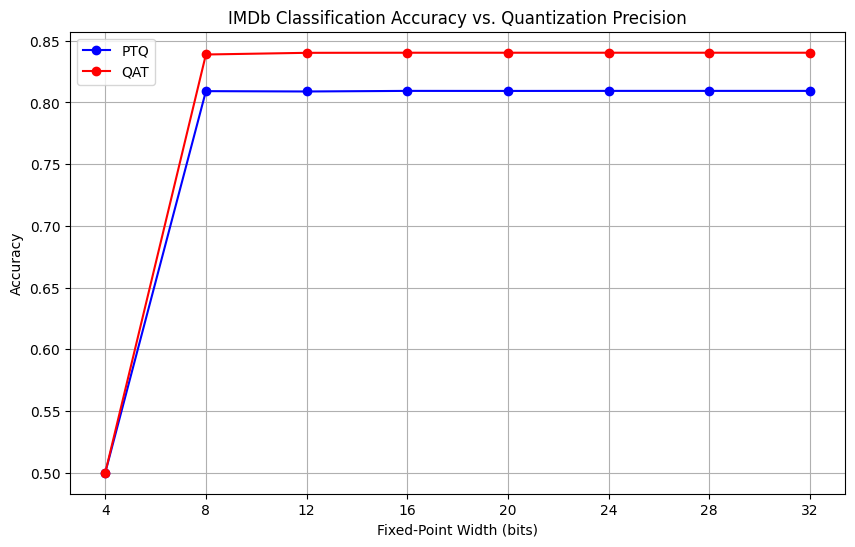

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
from chop import MaseGraph
import chop.passes as passes
from transformers import AutoModelForSequenceClassification
from chop.tools import get_tokenized_dataset, get_trainer



# Define fixed-point widths to test
fixed_point_widths = list(range(4, 33, 4))  # [4, 8, 12, 16, 20, 24, 28, 32]
ptq_accuracies = []
qat_accuracies = []

for width in fixed_point_widths:
    print(f"\n=== Testing Fixed-Point Width: {width} ===")

    # 1. Reload original model from checkpoint
    mg = MaseGraph.from_checkpoint(f"/content/drive/MyDrive/Colab Notebooks/IC/Advanced Deep Learning/tutorial_2_lora")
    # 2. Configure quantization for current width
    quantization_config = {
        "by": "type",
        "default": {"config": {"name": None}},
        "linear": {
            "config": {
                "name": "integer",
                "data_in_width": width,
                "data_in_frac_width": width - 2,
                "weight_width": width,
                "weight_frac_width": width - 2,
                "bias_width": width,
                "bias_frac_width": width - 2,
            }
        },
    }

    # 3. Apply PTQ
    mg, _ = passes.quantize_transform_pass(mg, pass_args=quantization_config)

    # 4. Evaluate PTQ accuracy
    ptq_trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
    )
    ptq_results = ptq_trainer.evaluate()
    ptq_acc = ptq_results["eval_accuracy"]
    ptq_accuracies.append(ptq_acc)
    print(f"PTQ Accuracy: {ptq_acc:.4f}")

    # 5. Configure QAT training
    qat_trainer = trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
    )

    # 6. Perform QAT
    qat_trainer.train()

    # 7. Evaluate QAT accuracy
    qat_results = qat_trainer.evaluate()
    qat_acc = qat_results["eval_accuracy"]
    qat_accuracies.append(qat_acc)
    print(f"QAT Accuracy: {qat_acc:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(fixed_point_widths, ptq_accuracies, "b-o", label="PTQ")
plt.plot(fixed_point_widths, qat_accuracies, "r-o", label="QAT")
plt.xlabel("Fixed-Point Width (bits)")
plt.ylabel("Accuracy")
plt.title("IMDb Classification Accuracy vs. Quantization Precision")
plt.legend()
plt.grid(True)
plt.xticks(fixed_point_widths)
plt.show()

# Understanding how many epoch of training until overfitting

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

INFO     Replaced node: bert_encoder_layer_0_attention_self_query, target: bert.encoder.layer.0.attention.self.query with LoRALinear module.
INFO     Replaced node: bert_encoder_layer_0_attention_self_key, target: bert.encoder.layer.0.attention.self.key with LoRALinear module.
INFO     Replaced node: bert_encoder_layer_0_attention_self_value, target: bert.encoder.layer.0.attention.self.value with LoRALinear module.
INFO     Replaced node: bert_encoder_layer_0_attention_output_dense, target: bert.encoder.layer.0.attention.output.dense with LoRALinear module.
INFO     Replaced node: bert_encoder_layer_0_intermediate_dense, target: bert.encoder.layer.0.intermediate.dense with LoRALinear module.
INFO     Replaced node: bert_encoder_layer_0_output_dense, target: bert.encoder.layer.0.output.dense with LoRALinear module.
INFO     Replaced node: bert_encoder_layer_1_attention_self_query, target: bert.encoder.layer.1.attention.self.query with LoRALinear module.
INFO     Replaced node: bert_enco


Training Epoch 1...


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.383700
1000,0.387400
1500,0.391700
2000,0.373000
2500,0.384900
3000,0.376800


INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.output.dense.
INFO     Fusing LoRALinear weights f

Epoch 1 Accuracy: 0.8452

Training Epoch 2...


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.356300
1000,0.367800
1500,0.374500
2000,0.360400
2500,0.377200
3000,0.373200


INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.output.dense.
INFO     Fusing LoRALinear weights f

Epoch 2 Accuracy: 0.8505

Training Epoch 3...


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.337700
1000,0.354500
1500,0.361800
2000,0.352200
2500,0.374100
3000,0.375100


INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.output.dense.
INFO     Fusing LoRALinear weights f

Epoch 3 Accuracy: 0.8534

Training Epoch 4...


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.316700
1000,0.346000
1500,0.351600
2000,0.342300
2500,0.372100
3000,0.381100


INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.output.dense.
INFO     Fusing LoRALinear weights f

Epoch 4 Accuracy: 0.8539

Training Epoch 5...


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.294200
1000,0.325200
1500,0.335000
2000,0.332400
2500,0.372600
3000,0.388200


INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.output.dense.
INFO     Fusing LoRALinear weights f

Epoch 5 Accuracy: 0.8544

Training Epoch 6...


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.268400
1000,0.292500
1500,0.323000
2000,0.329400
2500,0.378200
3000,0.401400


INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.output.dense.
INFO     Fusing LoRALinear weights f

Epoch 6 Accuracy: 0.8545

Training Epoch 7...


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.239000
1000,0.261200
1500,0.312400
2000,0.322100
2500,0.385800
3000,0.415300


INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.output.dense.
INFO     Fusing LoRALinear weights f

Epoch 7 Accuracy: 0.8547

Training Epoch 8...


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.211300
1000,0.232700
1500,0.299600
2000,0.317200
2500,0.391400
3000,0.430600


INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.output.dense.
INFO     Fusing LoRALinear weights f

Epoch 8 Accuracy: 0.8542

Training Epoch 9...


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.185800
1000,0.208800
1500,0.276800
2000,0.305400
2500,0.391400
3000,0.444800


INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.output.dense.
INFO     Fusing LoRALinear weights f

Epoch 9 Accuracy: 0.8527

Training Epoch 10...


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.159600
1000,0.191100
1500,0.251700
2000,0.293800
2500,0.399400
3000,0.462700


INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.0.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.query.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.key.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.self.value.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.attention.output.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.intermediate.dense.
INFO     Fusing LoRALinear weights for bert.encoder.layer.1.output.dense.
INFO     Fusing LoRALinear weights f

Epoch 10 Accuracy: 0.8506


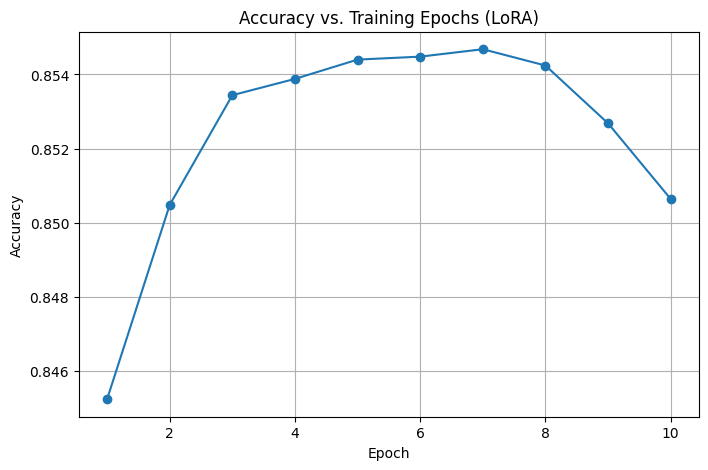

In [33]:
import matplotlib.pyplot as plt
from pathlib import Path
from chop import MaseGraph
from chop.tools import get_tokenized_dataset, get_trainer

checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"


# Load dataset and tokenizer
dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

# Store accuracy per epoch
accuracy_results = []

# Training loop for incremental training
for epoch in range(1, 11):
    print(f"\nTraining Epoch {epoch}...")

    # Apply LoRA (if not already applied)
    mg, _ = passes.insert_lora_adapter_transform_pass(
        mg,
        pass_args={
            "rank": 6,
            "alpha": 1.0,
            "dropout": 0.5,
        },
    )

    # Create trainer
    trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,  # Train for one epoch at a time
    )

    # Train incrementally
    trainer.train()

    # Evaluate and store results
    eval_results = trainer.evaluate()
    accuracy = eval_results["eval_accuracy"]
    accuracy_results.append(accuracy)
    print(f"Epoch {epoch} Accuracy: {accuracy:.4f}")

    # Fuse LoRA weights after training
    mg, _ = passes.fuse_lora_weights_transform_pass(mg)

# Plot accuracy trend over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), accuracy_results, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Training Epochs (LoRA)")
plt.grid()
plt.show()
